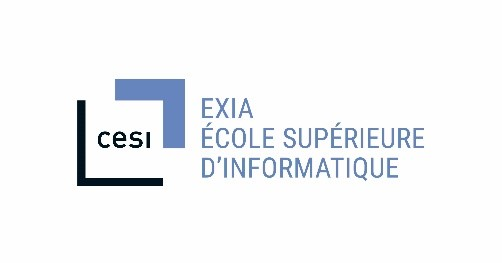


# **Livrable 03 - Image Captioning (PHASE 4)**

#### **Membre de groupe**

*   Djaffer Zinedine Ait Rabah
*   Soltane Benghezal
*   Fares Mounir Merzouk
*   Ghada Messaour
####  **Chef de groupe** 


*   Abdelhamid Larachi

#### **Pilote de Formation : Mr. Fayçal Khetar**
#### **Pilote de l'option : Mr. Hani Haroun Afrit**
---





 




# **Description du livrable**

Ce livrable concerne la dernière étape du traitement requis. L'objectif est de créer un réseau de neurones qui génère des légendes pour des photographies, en s'appuyant sur le dataset MS COCO. Le réseau sera composé de deux parties, la partie CNN qui encode les images en un représentation interne, et le partie RNN utilise cette représentation pour prédire l'annotation séquence par séquence. Avant l'entraînement du modèle les images sont prétraitées par un CNN pré-entrainé pour la classification.

Le livrable est un notebook Jupyter contenant :

* L'architecture schématique complète du réseau utilisé pour le captioning explicitant le type de CNN utilisé pour les prétraitements.
* Un petit descriptif sur le pré-traitements de images et du texte.
* Le code explicitant l'architecture du CNN et du RNN utilisés dans le captioning.
* L'évolution sous forme de courbes des performances du réseau pendant l'entrainement. Affichage de quelques exemples pour les tests.

# **I. Import  des dépendances et du dataset**

In [70]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from imageio import imread

## Télécharger et préparer le dataset MS-COCO

On va utiliser [MS-COCO dataset](http://cocodataset.org/#home) pour entraîner notre modèle. Le dataset contient plus de 82 000 images, chacune d'elle a au moins 5 annotations de légende différentes. Le code ci-dessous télécharge et extrait le dataset automatiquement.

In [19]:
# Download caption annotation files
annotation_folder = '/annotations/'
annotation_file = os.path.abspath('.') + '/annotations/captions_train2014.json' 

# Download image files
image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder
print(PATH)
print(annotation_file)

F:\AI/train2014/
F:\AI/annotations/captions_train2014.json


## Optionnel : Limiter la taille de l'ensemble d'entraînement
Pour accélérer l'entraînement, nous allons utilisé un sous-ensemble de 30 000 annotations et leurs images correspondantes pour entraîner notre modèle. Utiliser plus de données résulterait à augmenter la qualité du captioning. 

In [20]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [21]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [22]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [23]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> Outdoor event with spectators under umbrellas on rainy day. <end>


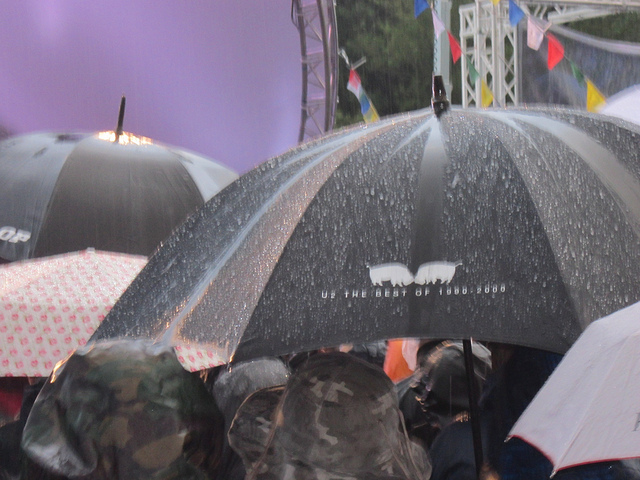

In [24]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Prétraiter les images en utilisant InceptionV3

Ensuite, on va utiliser InceptionV3 (déja pré-entraîné sur Imagenet) pour classifier chaque image. Nous allons extraire des composants de la dernière couche convolutive.

Premièrement, nous allons convertir les images dans le format attendu de InceptionV3 par :

* Redimensionner l'image à 299px par 299px
* [Prétraiter les images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) en utilisant la méthode [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) pour normaliser l'image pour qu'elle contienne des pixels entre -1 et 1, qui concorde avec le format des images utilisé pour entraîner InceptionV3.

In [25]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialiser InceptionV3 et charger les poids Imagenet pré-entraînés

Nous allons maintenant créer un modèle `tf.keras` où la couche de sortie est la dernière couche convolutive de l'architecture InceptionV3. La forme de la sortie de cette couche est ```8x8x2048```. Nous utilisons la dernière couche convolutive. Nous n'effectuons pas cette initialisation pendant la formation car cela pourrait devenir un goulot d'étranglement.

In [26]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Mise en cache des fonctionnalités extraites de InceptionV3

Nous prétraiterons chaque image avec InceptionV3 et mettrons en cache la sortie sur le disque. La mise en cache de la sortie dans la RAM serait plus rapide mais aussi gourmande en mémoire, nécessitant 8 \* 8 \* 2048 flottants par image.

Les performances pourraient être améliorées avec une stratégie de mise en cache plus sophistiquée (par exemple, en partitionnant les images pour réduire les E/S de disque à accès aléatoire).

In [27]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Prétraiter et tokeniser les captions

Nous allons transformer les descriptions en séquence d'entiers en utilisant la couche [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization), avec les étapes suivantes :

* Utiliser [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) pour itérer entre toutes les captions, diviser les captions en mots et calculer un vocabulaire du top 5 000 mots (pour sauvegarder la mémoire).
* Tokeniser toutes les captionsen mappant chaque mot à son indice dans le vocabulaire. Toutes les séquences en sortie seront paddé à la longueur 50.
* Créez des mappages mot-index et index-mot pour afficher les résultats.

In [28]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [29]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [30]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Diviser les données en entraînement et test

In [31]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24020, 24020, 6003, 6003)

## Créer un dataset tf.data pour l'entraînement

Toutes les images sont prêtes ! Maintenant, créons un dataset `tf.data` à utiliser pour entraîner notre modèle.

In [33]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [34]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Modèle

* Dans cet exemple, nous extrayons les caractéristiques de la couche convolutive inférieure d'InceptionV3 en nous donnant un vecteur de forme (8, 8, 2048).
* Nous écrasons cela en une forme de (64, 2048).
* Ce vecteur passe ensuite par l'encodeur CNN (qui consiste en une seule couche entièrement connectée).
* Le RNN (GRU dans ce cas-là) surveille l'image pour prédire le mot suivant.

In [36]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [37]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [38]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [39]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [40]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [41]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Entraînement

* Nous extrayons les fonctionnalités stockées dans les fichiers `.npy` respectifs, puis transmettons ces fonctionnalités via l'encodeur.
* La sortie de l'encodeur, l'état caché (initialisé à 0) et l'entrée du décodeur (qui est le jeton de démarrage) sont transmises au décodeur.
* Le décodeur renvoie les prédictions et l'état caché du décodeur.
* L'état caché du décodeur est ensuite renvoyé dans le modèle et les prédictions sont utilisées pour calculer la perte.
* Utilisez le forçage de l'enseignant pour décider de la prochaine entrée dans le décodeur.
* Le forçage de l'enseignant est la technique dans laquelle le mot cible est transmis comme entrée suivante au décodeur.
* La dernière étape consiste à calculer les gradients et à les appliquer à l'optimiseur et à la rétropropagation.

In [43]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [44]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [45]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 4 Batch 0 Loss 1.9796
Epoch 4 Batch 100 Loss 0.9968
Epoch 4 Batch 200 Loss 0.9112
Epoch 4 Batch 300 Loss 0.8778
Epoch 4 Loss 0.958733
Time taken for 1 epoch 635.55 sec

Epoch 5 Batch 0 Loss 0.8161
Epoch 5 Batch 100 Loss 0.7730
Epoch 5 Batch 200 Loss 0.7397
Epoch 5 Batch 300 Loss 0.6991
Epoch 5 Loss 0.738683
Time taken for 1 epoch 593.52 sec

Epoch 6 Batch 0 Loss 0.7340
Epoch 6 Batch 100 Loss 0.6479
Epoch 6 Batch 200 Loss 0.6197
Epoch 6 Batch 300 Loss 0.6848
Epoch 6 Loss 0.659789
Time taken for 1 epoch 642.39 sec

Epoch 7 Batch 0 Loss 0.6546
Epoch 7 Batch 100 Loss 0.5577
Epoch 7 Batch 200 Loss 0.5789
Epoch 7 Batch 300 Loss 0.5821
Epoch 7 Loss 0.604820
Time taken for 1 epoch 789.50 sec

Epoch 8 Batch 0 Loss 0.5626
Epoch 8 Batch 100 Loss 0.5269
Epoch 8 Batch 200 Loss 0.5941
Epoch 8 Batch 300 Loss 0.5359
Epoch 8 Loss 0.560052
Time taken for 1 epoch 803.12 sec

Epoch 9 Batch 0 Loss 0.5870
Epoch 9 Batch 100 Loss 0.5054
Epoch 9 Batch 200 Loss 0.4715
Epoch 9 Batch 300 Loss 0.5731
Epoch 9

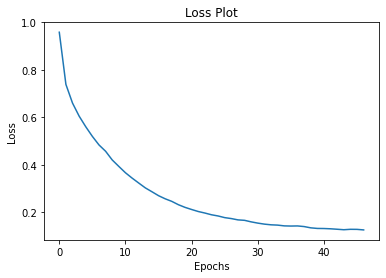

In [46]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Captioning

* La fonction d'évaluation est similaire à la boucle d'entraînement, sauf que vous n'utilisez pas le forçage de l'enseignant ici. L'entrée du décodeur à chaque pas de temps correspond à ses prédictions précédentes ainsi qu'à l'état caché et à la sortie du codeur.
* Arrêtez de prédire lorsque le modèle prédit le jeton de fin.
* Et stockez les pondérations d'attention pour chaque pas de temps.

In [47]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [48]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> there is a small stuffed bear on top of a machine <end>
Prediction Caption: a large white cream from a pink tie. <end>


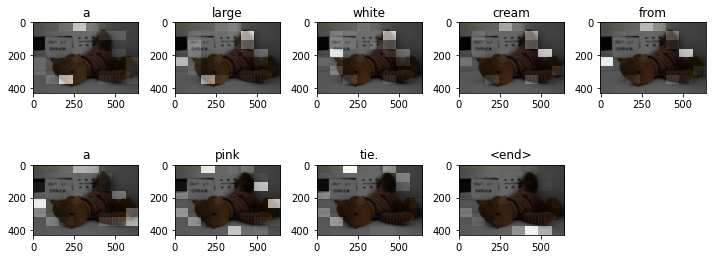

In [49]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Test sur nos propres images

nous avons fourni une méthode que nous pouvons utiliser pour captionner nos propres images avec le modèle que nous venons d'entraîner. Gardons à l'esprit qu'il a été formé sur une quantité relativement faible de données et que nos images peuvent être différentes des données de formation.

In [68]:
def GetCaption(image_url):
    image_path = tf.keras.utils.get_file(origin=image_url)
    result, attention_plot = evaluate(image_path)
    print('Prediction Caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    # opening the image
    plt.imshow(imread(image_url))

Prediction Caption: a male [UNK] boarder is in the waves. <end>


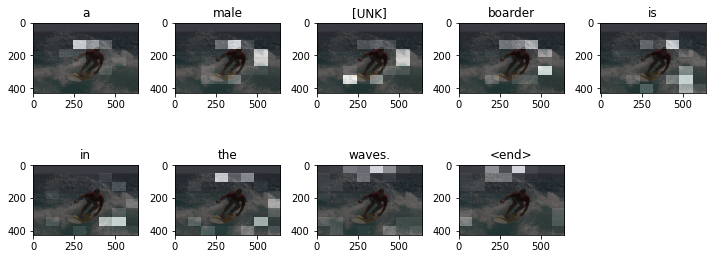

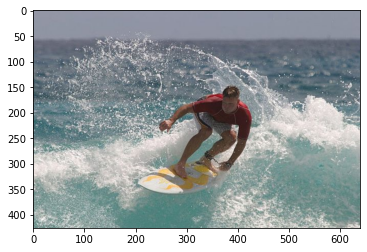

In [73]:
GetCaption('https://tensorflow.org/images/surf.jpg')

Prediction Caption: a cat laying down the lot next to a potted plant. <end>


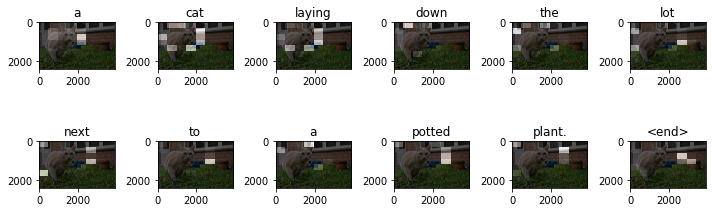

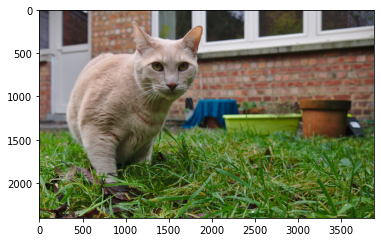

In [74]:
GetCaption('https://upload.wikimedia.org/wikipedia/commons/3/32/Larry_the_cat_walking_cautiously_on_grass_in_Auderghem%2C_Belgium_%28DSCF2353%29.jpg')

Prediction Caption: a man is riding a plastic on a skier in the air above a clear blue sky. <end>


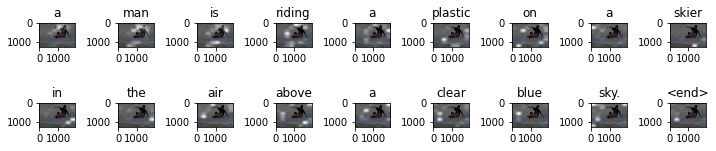

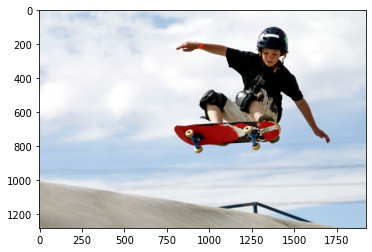

In [78]:
GetCaption('https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/MA_00658277_vwlk3l.jpg')

Prediction Caption: a young man is standing next to a dog and [UNK] <end>


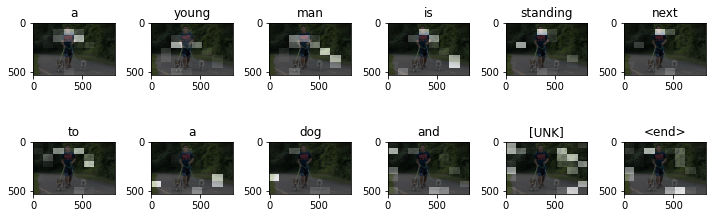

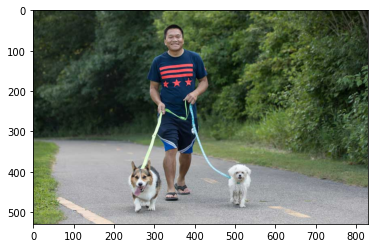

In [99]:
GetCaption('https://www.threeriversparks.org/sites/default/files/inline-images/Internal%20-%20dog%20walking%20summer.jpg')

## Conclusion

Après le test sur nos images, nous remarquons que la caption de la première image concorde avec le contenu de l'image mais le résultat est moins convaincant avec la deuxième image. Notre modèle reste précis mais avec aproximativement 0.1 en loss, c'est plus difficile pour l'opération de captioning.